```
by Svitlana Midianko, Spring 2021
```

# 1. Building the classes and functionality

In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from copy import deepcopy

In [2]:
class Game:
    def __init__(self):
        self._init()

    def _init(self):
        self.selected = None
        self.board = Board()
        self.turn = RED
        self.valid_moves = {}

    def winner(self):
        return self.board.winner()

    def reset(self):
        self._init()

    def select(self, row, col):
        if self.selected:
            result = self._move(row, col)
            if not result:
                self.selected = None
                self.select(row, col)
        
        piece = self.board.get_piece(row, col)
        if piece != 0 and piece.color == self.turn:
            self.selected = piece
            self.valid_moves = self.board.get_valid_moves(piece)
            return True
            
        return False

    def _move(self, row, col):
        piece = self.board.get_piece(row, col)
        if self.selected and piece == 0 and (row, col) in self.valid_moves:
            self.board.move(self.selected, row, col)
            skipped = self.valid_moves[(row, col)]
            if skipped:
                self.board.remove(skipped)
            self.change_turn()
        else:
            return False

        return True

    def change_turn(self):
        self.valid_moves = {}
        if self.turn == RED:
            self.turn = WHITE
        else:
            self.turn = RED

    def get_board(self):
        return self.board

    def ai_move(self, board):
        self.board = board
        self.change_turn()

In [9]:
def minimax(position, depth, max_player, game):
    if depth == 0 or position.winner() != None:
        return position.evaluate(), position
    
    if max_player:

        maxEval = float('-inf')
        best_move = None
    
        for move in get_all_moves(position, WHITE, game)[0]:
            evaluation = minimax(move, depth-1, False, game)[0]
            maxEval = max(maxEval, evaluation)
            if maxEval == evaluation:
                best_move = move
        
        return maxEval, best_move
    else:
     
        minEval = float('inf')
        best_move = None
        for move in get_all_moves(position, BLACK, game)[0]:
            evaluation = minimax(move, depth-1, True, game)[0]
            minEval = min(minEval, evaluation)
            if minEval == evaluation:
                best_move = move
        
        return minEval, best_move

def simulate_move(piece, move, board, game, skip):
    board.move(piece, move[0], move[1])
    if skip:
        board.remove(skip)
    return board

def get_all_moves(board, color, game):
    moves = []
    valid_coordinates = dict()
    print('-----')
    vizualize_board(board.board)
    print('All pieces', board.get_all_pieces(color))
    for i in board.get_all_pieces(color): 
      print(i.row, i.col)
    for piece in board.get_all_pieces(color):
      print('piece', piece.row, piece.col)
      
      valid_moves = board.get_valid_moves(piece) 
      print('valid moves', valid_moves)
      for move, skip in valid_moves.items():
          temp_board = deepcopy(board)
          temp_piece = temp_board.get_piece(piece.row, piece.col)
          #print(temp_piece)
          new_board = simulate_move(temp_piece, move, temp_board, game, skip)
      
          moves.append(new_board)
          valid_coordinates[(piece.row,piece.col,move[0],move[1])] = skip
  
    return moves, valid_coordinates

In [38]:
class Piece:
    def __init__(self, row, col, color):
        self.row = row
        self.col = col
        self.color = color
        self.king = False
        self.numerized_color = -1 if self.color == 'WHITE' else 1


    def make_king(self):
        self.king = True

    def move(self, row, col):
        self.row = row
        self.col = col

    def __repr__(self):
        return str(self.color)

In [35]:
ROWS = 8
COLS = 8
WHITE = "WHITE"
BLACK = "BLACK"
RED = BLACK

class Board:
    def __init__(self):
        self.board = []
        self.red_left = self.white_left = 12
        self.red_kings = self.white_kings = 0
        self.create_board()

    def evaluate(self):
        return self.white_left - self.red_left + (self.white_kings * 0.5 - self.red_kings * 0.5)


    def get_all_pieces(self, color):
        pieces = []
        for row in self.board:
            for piece in row:
                if piece != 0 and piece.color == color:
                    pieces.append(piece)
        return pieces

    def move(self, piece, row, col):
        self.board[piece.row][piece.col], self.board[row][col] = self.board[row][col], self.board[piece.row][piece.col]
        piece.move(row, col)

        if row == ROWS - 1 or row == 0:
            piece.make_king()
            if piece.color == WHITE:
                self.white_kings += 1
            else:
                self.red_kings += 1 

    def get_piece(self, row, col):
        return self.board[row][col]

    def create_board(self):
        for row in range(ROWS):
            self.board.append([])
            for col in range(COLS):
                if col % 2 == ((row +  1) % 2):
                    if row < 3:
                        self.board[row].append(Piece(row, col, WHITE))
                    elif row > 4:
                        self.board[row].append(Piece(row, col, RED))
                    else:
                        self.board[row].append(0)
                else:
                    self.board[row].append(0)

    def remove(self, pieces):
        for piece in pieces:
            self.board[piece.row][piece.col] = 0
            if piece != 0:
                if piece.color == RED:
                    self.red_left -= 1
                else:
                    self.white_left -= 1
    
    def winner(self):
        if self.red_left <= 0:
            return WHITE
        elif self.white_left <= 0:
            return RED
        
        return None 
    
    def get_valid_moves(self, piece):
        moves = {}
        left = piece.col - 1
        right = piece.col + 1
        row = piece.row

        if piece.color == RED or piece.king:
            moves.update(self._traverse_left(row -1, max(row-3, -1), -1, piece.color, left))
            moves.update(self._traverse_right(row -1, max(row-3, -1), -1, piece.color, right))
        if piece.color == WHITE or piece.king:
            moves.update(self._traverse_left(row +1, min(row+3, ROWS), 1, piece.color, left))
            moves.update(self._traverse_right(row +1, min(row+3, ROWS), 1, piece.color, right))
    
        return moves

    def _traverse_left(self, start, stop, step, color, left, skipped=[]):
        moves = {}
        last = []
        for r in range(start, stop, step):
            if left < 0:
                break
            
            current = self.board[r][left]
            if current == 0:
                if skipped and not last:
                    break
                elif skipped:
                    moves[(r, left)] = last + skipped
                else:
                    moves[(r, left)] = last
                
                if last:
                    if step == -1:
                        row = max(r-3, 0)
                    else:
                        row = min(r+3, ROWS)
                    moves.update(self._traverse_left(r+step, row, step, color, left-1,skipped=last))
                    moves.update(self._traverse_right(r+step, row, step, color, left+1,skipped=last))
                break
            elif current.color == color:
                break
            else:
                last = [current]

            left -= 1
        
        return moves

    def _traverse_right(self, start, stop, step, color, right, skipped=[]):
        moves = {}
        last = []
        for r in range(start, stop, step):
            if right >= COLS:
                break
            
            current = self.board[r][right]
            if current == 0:
                if skipped and not last:
                    break
                elif skipped:
                    moves[(r,right)] = last + skipped
                else:
                    moves[(r, right)] = last
                
                if last:
                    if step == -1:
                        row = max(r-3, 0)
                    else:
                        row = min(r+3, ROWS)
                    moves.update(self._traverse_left(r+step, row, step, color, right-1,skipped=last))
                    moves.update(self._traverse_right(r+step, row, step, color, right+1,skipped=last))
                break
            elif current.color == color:
                break
            else:
                last = [current]

            right += 1
        
        return moves

In [5]:
def vizualize_board(board, show = True):
  '''
  Function that converts grid filled with objects to array with numbers
  so that it can be vizualized.
  If show = True, then it is also vizualized.
  '''  
  board_copy = np.array(board)
  numerized_board = np.empty(board_copy.shape)
  cmap = colors.ListedColormap(['white', 'burlywood', 'black'])
  global COLS, ROWS
  for i in range(ROWS): 
    for j in range(COLS): 
      if isinstance(board[i][j], Piece): 
        numerized_board[i, j] = board[i][j].numerized_color
      else: 
        numerized_board[i,j] =0

  if show:
    # making the final plot.
    fig, ax = plt.subplots()
    ax.get_yticks()
    ax.imshow(numerized_board, cmap = cmap)
    x_ticks_ = list(range(board_copy.shape[1]))
    y_ticks_ = list(range(board_copy.shape[0]))
    ax.set_xticks(x_ticks_)
    ax.set_yticks(y_ticks_)
    plt.show()


hi, human plays
-----


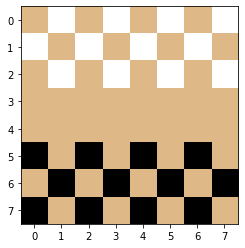

viz from get all pieces


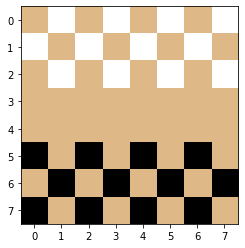

41 cell is <class 'int'> 94238332774880 0
50 cell is <class '__main__.Piece'> 140154125874384 BLACK
0 0 94238332774880
0 1 140154136801936
Selected in isinstance 0 1
0 2 94238332774880
0 3 140154136803216
Selected in isinstance 0 3
0 4 94238332774880
0 5 140154136802320
Selected in isinstance 0 5
0 6 94238332774880
0 7 140154136804496
Selected in isinstance 0 7
1 0 140154136804624
Selected in isinstance 1 0
1 1 94238332774880
1 2 140154136802192
Selected in isinstance 1 2
1 3 94238332774880
1 4 140154136803792
Selected in isinstance 1 4
1 5 94238332774880
1 6 140154136802896
Selected in isinstance 1 6
1 7 94238332774880
2 0 94238332774880
2 1 140154136803600
Selected in isinstance 2 1
2 2 94238332774880
2 3 140154136803728
Selected in isinstance 2 3
2 4 94238332774880
2 5 140154136804304
Selected in isinstance 2 5
2 6 94238332774880
2 7 140154136802448
Selected in isinstance 2 7
3 0 94238332774880
3 1 94238332774880
3 2 94238332774880
3 3 94238332774880
3 4 94238332774880
3 5 942383327

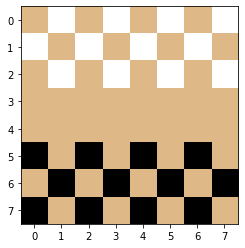

41 cell is <class 'int'> 94238332774880 0
50 cell is <class '__main__.Piece'> 140154125874384 BLACK
0 0 94238332774880
0 1 140154136801936
Selected in isinstance 0 1
0 2 94238332774880
0 3 140154136803216
Selected in isinstance 0 3
0 4 94238332774880
0 5 140154136802320
Selected in isinstance 0 5
0 6 94238332774880
0 7 140154136804496
Selected in isinstance 0 7
1 0 140154136804624
Selected in isinstance 1 0
1 1 94238332774880
1 2 140154136802192
Selected in isinstance 1 2
1 3 94238332774880
1 4 140154136803792
Selected in isinstance 1 4
1 5 94238332774880
1 6 140154136802896
Selected in isinstance 1 6
1 7 94238332774880
2 0 94238332774880
2 1 140154136803600
Selected in isinstance 2 1
2 2 94238332774880
2 3 140154136803728
Selected in isinstance 2 3
2 4 94238332774880
2 5 140154136804304
Selected in isinstance 2 5
2 6 94238332774880
2 7 140154136802448
Selected in isinstance 2 7
3 0 94238332774880
3 1 94238332774880
3 2 94238332774880
3 3 94238332774880
3 4 94238332774880
3 5 942383327

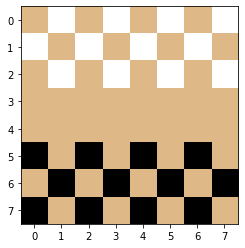

41 cell is <class 'int'> 94238332774880 0
50 cell is <class '__main__.Piece'> 140154125874384 BLACK
0 0 94238332774880
0 1 140154136801936
Selected in isinstance 0 1
0 2 94238332774880
0 3 140154136803216
Selected in isinstance 0 3
0 4 94238332774880
0 5 140154136802320
Selected in isinstance 0 5
0 6 94238332774880
0 7 140154136804496
Selected in isinstance 0 7
1 0 140154136804624
Selected in isinstance 1 0
1 1 94238332774880
1 2 140154136802192
Selected in isinstance 1 2
1 3 94238332774880
1 4 140154136803792
Selected in isinstance 1 4
1 5 94238332774880
1 6 140154136802896
Selected in isinstance 1 6
1 7 94238332774880
2 0 94238332774880
2 1 140154136803600
Selected in isinstance 2 1
2 2 94238332774880
2 3 140154136803728
Selected in isinstance 2 3
2 4 94238332774880
2 5 140154136804304
Selected in isinstance 2 5
2 6 94238332774880
2 7 140154136802448
Selected in isinstance 2 7
3 0 94238332774880
3 1 94238332774880
3 2 94238332774880
3 3 94238332774880
3 4 94238332774880
3 5 942383327

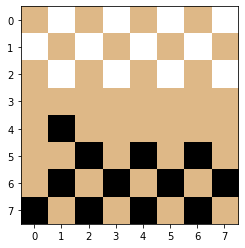

viz from get all pieces


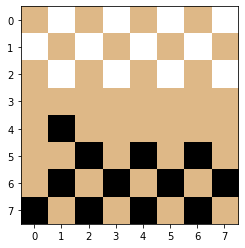

41 cell is <class '__main__.Piece'> 140154127633296 BLACK
50 cell is <class 'int'> 94238332774880 0
0 0 94238332774880
0 1 140154127632144
Selected in isinstance 0 1
0 2 94238332774880
0 3 140154127634128
Selected in isinstance 0 3
0 4 94238332774880
0 5 140154127630992
Selected in isinstance 0 5
0 6 94238332774880
0 7 140154127632784
Selected in isinstance 0 7
1 0 140154127632528
Selected in isinstance 1 0
1 1 94238332774880
1 2 140154127633680
Selected in isinstance 1 2
1 3 94238332774880
1 4 140154127634320
Selected in isinstance 1 4
1 5 94238332774880
1 6 140154127633168
Selected in isinstance 1 6
1 7 94238332774880
2 0 94238332774880
2 1 140154127631248
Selected in isinstance 2 1
2 2 94238332774880
2 3 140154127633872
Selected in isinstance 2 3
2 4 94238332774880
2 5 140154127632464
Selected in isinstance 2 5
2 6 94238332774880
2 7 140154127631440
Selected in isinstance 2 7
3 0 94238332774880
3 1 94238332774880
3 2 94238332774880
3 3 94238332774880
3 4 94238332774880
3 5 942383327

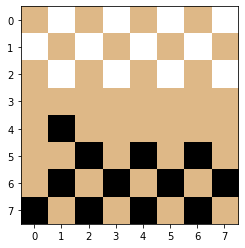

41 cell is <class '__main__.Piece'> 140154127633296 BLACK
50 cell is <class 'int'> 94238332774880 0
0 0 94238332774880
0 1 140154127632144
Selected in isinstance 0 1
0 2 94238332774880
0 3 140154127634128
Selected in isinstance 0 3
0 4 94238332774880
0 5 140154127630992
Selected in isinstance 0 5
0 6 94238332774880
0 7 140154127632784
Selected in isinstance 0 7
1 0 140154127632528
Selected in isinstance 1 0
1 1 94238332774880
1 2 140154127633680
Selected in isinstance 1 2
1 3 94238332774880
1 4 140154127634320
Selected in isinstance 1 4
1 5 94238332774880
1 6 140154127633168
Selected in isinstance 1 6
1 7 94238332774880
2 0 94238332774880
2 1 140154127631248
Selected in isinstance 2 1
2 2 94238332774880
2 3 140154127633872
Selected in isinstance 2 3
2 4 94238332774880
2 5 140154127632464
Selected in isinstance 2 5
2 6 94238332774880
2 7 140154127631440
Selected in isinstance 2 7
3 0 94238332774880
3 1 94238332774880
3 2 94238332774880
3 3 94238332774880
3 4 94238332774880
3 5 942383327

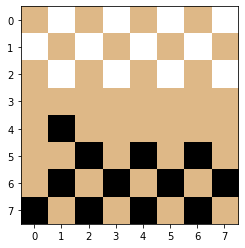

41 cell is <class '__main__.Piece'> 140154127633296 BLACK
50 cell is <class 'int'> 94238332774880 0
0 0 94238332774880
0 1 140154127632144
Selected in isinstance 0 1
0 2 94238332774880
0 3 140154127634128
Selected in isinstance 0 3
0 4 94238332774880
0 5 140154127630992
Selected in isinstance 0 5
0 6 94238332774880
0 7 140154127632784
Selected in isinstance 0 7
1 0 140154127632528
Selected in isinstance 1 0
1 1 94238332774880
1 2 140154127633680
Selected in isinstance 1 2
1 3 94238332774880
1 4 140154127634320
Selected in isinstance 1 4
1 5 94238332774880
1 6 140154127633168
Selected in isinstance 1 6
1 7 94238332774880
2 0 94238332774880
2 1 140154127631248
Selected in isinstance 2 1
2 2 94238332774880
2 3 140154127633872
Selected in isinstance 2 3
2 4 94238332774880
2 5 140154127632464
Selected in isinstance 2 5
2 6 94238332774880
2 7 140154127631440
Selected in isinstance 2 7
3 0 94238332774880
3 1 94238332774880
3 2 94238332774880
3 3 94238332774880
3 4 94238332774880
3 5 942383327

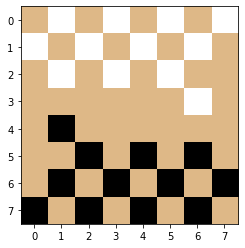

viz from get all pieces


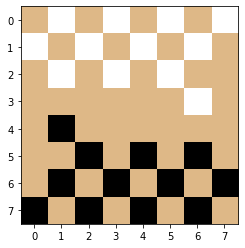

41 cell is <class '__main__.Piece'> 140154137760464 BLACK
50 cell is <class 'int'> 94238332774880 0
0 0 94238332774880
0 1 140154137760912
Selected in isinstance 0 1
0 2 94238332774880
0 3 140154137760016
Selected in isinstance 0 3
0 4 94238332774880
0 5 140154137760336
Selected in isinstance 0 5
0 6 94238332774880
0 7 140154137759824
Selected in isinstance 0 7
1 0 140154137762576
Selected in isinstance 1 0
1 1 94238332774880
1 2 140154137761040
Selected in isinstance 1 2
1 3 94238332774880
1 4 140154137761744
Selected in isinstance 1 4
1 5 94238332774880
1 6 140154137761808
Selected in isinstance 1 6
1 7 94238332774880
2 0 94238332774880
2 1 140154137761360
Selected in isinstance 2 1
2 2 94238332774880
2 3 140154137762896
Selected in isinstance 2 3
2 4 94238332774880
2 5 140154137761296
Selected in isinstance 2 5
2 6 94238332774880
2 7 94238332774880
3 0 94238332774880
3 1 94238332774880
3 2 94238332774880
3 3 94238332774880
3 4 94238332774880
3 5 94238332774880
3 6 140154137761872
Se

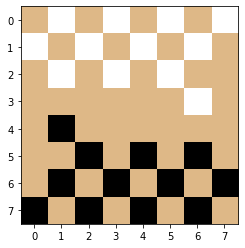

41 cell is <class '__main__.Piece'> 140154137760464 BLACK
50 cell is <class 'int'> 94238332774880 0
0 0 94238332774880
0 1 140154137760912
Selected in isinstance 0 1
0 2 94238332774880
0 3 140154137760016
Selected in isinstance 0 3
0 4 94238332774880
0 5 140154137760336
Selected in isinstance 0 5
0 6 94238332774880
0 7 140154137759824
Selected in isinstance 0 7
1 0 140154137762576
Selected in isinstance 1 0
1 1 94238332774880
1 2 140154137761040
Selected in isinstance 1 2
1 3 94238332774880
1 4 140154137761744
Selected in isinstance 1 4
1 5 94238332774880
1 6 140154137761808
Selected in isinstance 1 6
1 7 94238332774880
2 0 94238332774880
2 1 140154137761360
Selected in isinstance 2 1
2 2 94238332774880
2 3 140154137762896
Selected in isinstance 2 3
2 4 94238332774880
2 5 140154137761296
Selected in isinstance 2 5
2 6 94238332774880
2 7 94238332774880
3 0 94238332774880
3 1 94238332774880
3 2 94238332774880
3 3 94238332774880
3 4 94238332774880
3 5 94238332774880
3 6 140154137761872
Se

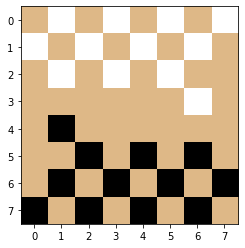

41 cell is <class '__main__.Piece'> 140154137760464 BLACK
50 cell is <class 'int'> 94238332774880 0
0 0 94238332774880
0 1 140154137760912
Selected in isinstance 0 1
0 2 94238332774880
0 3 140154137760016
Selected in isinstance 0 3
0 4 94238332774880
0 5 140154137760336
Selected in isinstance 0 5
0 6 94238332774880
0 7 140154137759824
Selected in isinstance 0 7
1 0 140154137762576
Selected in isinstance 1 0
1 1 94238332774880
1 2 140154137761040
Selected in isinstance 1 2
1 3 94238332774880
1 4 140154137761744
Selected in isinstance 1 4
1 5 94238332774880
1 6 140154137761808
Selected in isinstance 1 6
1 7 94238332774880
2 0 94238332774880
2 1 140154137761360
Selected in isinstance 2 1
2 2 94238332774880
2 3 140154137762896
Selected in isinstance 2 3
2 4 94238332774880
2 5 140154137761296
Selected in isinstance 2 5
2 6 94238332774880
2 7 94238332774880
3 0 94238332774880
3 1 94238332774880
3 2 94238332774880
3 3 94238332774880
3 4 94238332774880
3 5 94238332774880
3 6 140154137761872
Se

KeyboardInterrupt: ignored

In [39]:
def main():
  run = True
  game = Game()

  while run:
    if game.turn == WHITE:
      print('hi PC plays, this was his move')
      value, new_board = minimax(position=game.get_board(),depth=1, max_player=True,game = game)
      print(new_board)
      game.ai_move(new_board)
    else:
      print('hi, human plays')
      possible_moves = get_all_moves(game.get_board(),BLACK, game)[1]
      print('Possible moves',possible_moves)
      print(game.board.board)
      valid = False
      while not valid:
        checker_to_move = [int(x) for x in input("Please type the CHECKER's ID that you want to move.\n  Checker's ID is in a form 'row_num, col_num'. E.g. the upper right corner ID is `07`: ")]
        place_to_move = [int(x) for x in input("Please type the PLACE's ID that you want to move.\n  Place's ID is in a form 'row_num, col_num'. E.g. the upper right corner ID is `07`: ")]
        if (tuple(checker_to_move)+tuple(place_to_move)) in possible_moves.keys():
          valid = True
          skip = possible_moves[tuple(checker_to_move)+tuple(place_to_move)]
        else:
          print('Invalid move. please try again')

      piece = game.get_board().get_piece(int(checker_to_move[0]), int(checker_to_move[1]))
      new_board = simulate_move(piece, place_to_move, deepcopy(game.get_board()), game, skip)
      game.board = new_board
      game.change_turn()

    if game.winner() != None:
        print(game.winner())
        run = False

main()


### Helper functions

In [ ]:
game = Game()
boards,moves = get_all_moves(game.get_board(),BLACK, game)
for board in boards:
  vizualize_board(board.board)
print(moves)

# 2. Simulation and Analysis